# Agarose phantom analysis

We want to demonstrate phase-contrast OPT

Using an agarose phantom (one cylinder embedded inside another, with different refractive indices)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from scipy import ndimage
import cv2
from tqdm import tqdm

## Reading in the images

In [2]:
# filepath on Predator machine
img_dir = r'D:\MSci_Project\1_Data\2023-03-17'
phantom = io.imread(img_dir + r'\2023-03-17 phase gradient phantom fullstack.tif')

# filepath on mac
# img_dir = '../../OPT Shared files/1_Data/2023-03-17/'
# phantom = io.imread(img_dir + '2023-03-17 phase gradient phantom fullstack.tif')
phantom = phantom.reshape((400,4,1392,1040)).astype('float32')

In [3]:
im_width = 1040
im_height = 1392
e = 6.45e-3 # Pixel size (mm)

Reshape into dimensions
* 400 (projections)
* 4 (illuminations)
* 1392 (height)
* 1040 (width)

In [4]:
X, Y = np.meshgrid(np.arange(0,im_width)*e, np.arange(0,im_height)[::-1]*e, indexing='xy' )

In [5]:
projection = 0
# Find minimum and maximum of stack
vmin = np.min(phantom[projection][0:4])
vmax = np.max(phantom[projection][0:4])
vmin, vmax

(606.0, 5163.0)

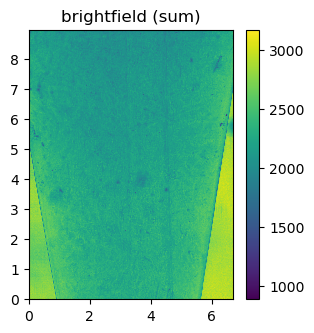

In [6]:
plt.figure(figsize=(3.3, 3.5))
plt.pcolormesh(X, Y, np.average(phantom[0], axis=0)) 
plt.title('brightfield (sum)')
plt.colorbar()
# ax[0].axis('off')

In [7]:
X, Y = np.meshgrid(np.arange(0,im_width)*e, np.arange(0,im_height)[::-1]*e, indexing='xy' )

606.0 5163.0


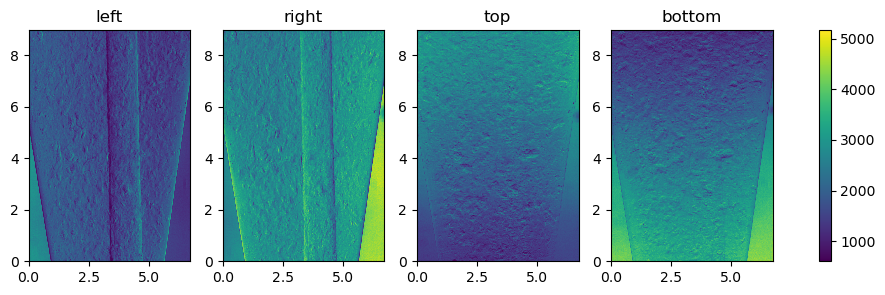

In [8]:
title_labels = ['left','right', 'top', 'bottom']
fig, axes = plt.subplots(1,4, figsize=(12,3))

vmin = np.min(phantom[projection])
vmax = np.max(phantom[projection])

print(vmin, vmax)

for i, ax in enumerate(axes.flat):
    im = ax.pcolormesh(X, Y, phantom[projection][i], vmin=vmin, vmax=vmax, cmap='viridis')
    ax.set_title(title_labels[i], fontsize=12)
    # ax[i].set_xlabel('Length (mm)')

# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im, ax=axes.ravel().tolist())

# plt.suptitle('Raw images divided by background')

In [9]:
background = io.imread(img_dir + r'\2023-03-17 phase gradient background.tif').astype('float32')[0:]

def get_averaged_stack(im_stack, num_repeats):
    # Gets averaged image stack, assuming shape of image stack is (num_repeats * z_stack_depth, im_height, im_width)
    # num_repeats (int): number of averaged images
    # SIMILAR TO calibrations/lens_aperture.ipynb, but order is reversed
    num_repeats = int(num_repeats)

    dim_0, im_length, im_width = im_stack.shape
    reshaped = im_stack.reshape(num_repeats, dim_0//num_repeats, im_length, im_width)
    output = np.mean(reshaped, axis=0)
    return output

background = get_averaged_stack(background, 5)
# np.max(background[4])
# plt.imshow(background.reshape(5,4, 1392, 1040)[2,0,:,:])

Background
* Important to see that it is working correctly

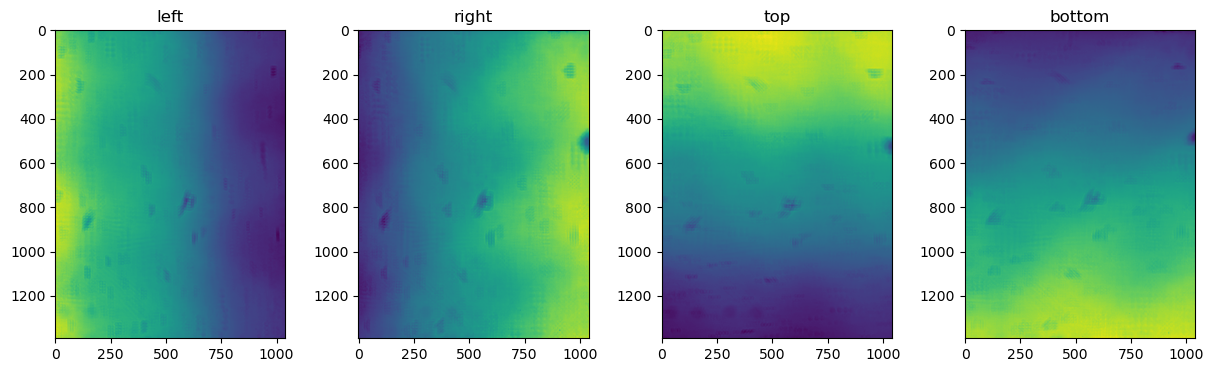

In [10]:
title_labels = ['left','right', 'top', 'bottom']
fig, ax = plt.subplots(1,4 ,figsize=(15, 4))
for i in range(4):
    ax[i].imshow(background[i])
    ax[i].set_title(title_labels[i])

Parthasarathy et al 2012 do not specify background subtraction. Background division seems logical?

In [12]:
#phantom -= background
phantom /= background

0.20354788 2.8426595


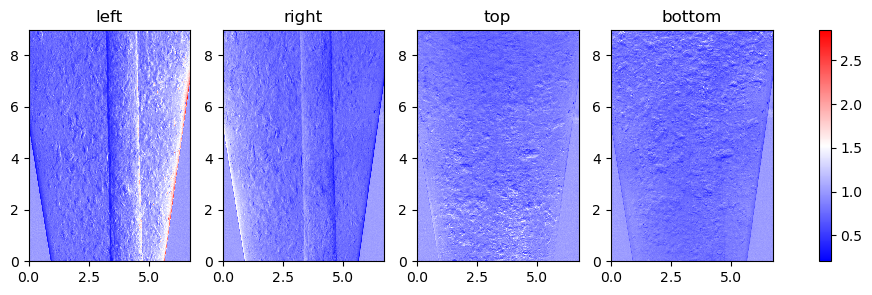

In [13]:
# title_labels = ['left','right', 'top', 'bottom']
# fig, ax = plt.subplots(1,5 ,figsize=(20, 6))

# ax[0].imshow(np.average(phantom[0], axis=0), cmap='gray')
# ax[0].set_title('brightfield (sum)')
# ax[0].axis('off')

# for i in range(4):
#     ax[i+1].imshow(phantom[0][i], cmap='bwr')
#     ax[i+1].set_title(title_labels[i])
#     ax[i+1].axis('off')

title_labels = ['left','right', 'top', 'bottom']
fig, axes = plt.subplots(1,4, figsize=(12,3))

vmin = np.min(phantom[projection])
vmax = np.max(phantom[projection])

print(vmin, vmax)

for i, ax in enumerate(axes.flat):
    im = ax.pcolormesh(X, Y, phantom[0][i], vmin=vmin, vmax=vmax, cmap='bwr')
    ax.set_title(title_labels[i], fontsize=12)
    # ax[i].set_xlabel('Length (mm)')

# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im, ax=axes.ravel().tolist())

In [14]:
phantom.shape, background.shape

((400, 4, 1392, 1040), (4, 1392, 1040))

Convert intensity images into wavefront tilt.

In [15]:
NA = 0.03 # Numerical aperture of f/d
lamb = 0.650 # in microns
factor = 2*np.pi/lamb*NA
left_right =  factor*(phantom[:,1,:,:] - phantom[:,0,:,:])/np.sum(phantom[:,0:2,:,:], axis=(1))
top_bottom = factor*(phantom[:,2,:,:] - phantom[:,3,:,:])/np.sum(phantom[:,2:,:,:], axis=(1))

In [16]:
factor

0.28999316802367314

## Phase gradient

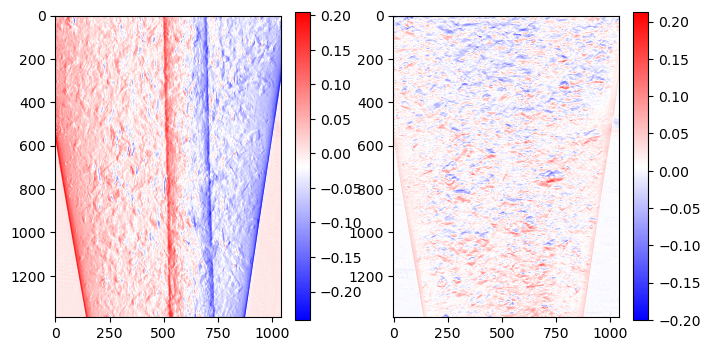

In [17]:
slice = 0
fig, ax = plt.subplots(1,2, figsize=(8,4))
lr_im = ax[0].imshow(left_right[slice], cmap='bwr')
plt.colorbar(lr_im)
tb_im = ax[1].imshow(top_bottom[slice], cmap='bwr')

plt.colorbar(tb_im)
# ax[0].imshow(np.average(phantom[slice], axis=0), cmap='gray')
# ax[0].set_title('brightfield (sum)')
# ax[0].axis('off')

### 2D Fourier integral method

$$ \Phi (x, y) = \mathcal{F}^{-1} [\frac{\mathcal{F}[\Phi_x + i \Phi_y](k, l)}{2\pi i (k + il)}](x, y) = \mathcal{F}^{-1} [\frac{\mathcal{F}[g](k, l)}{2\pi i (k + il)}](x, y) $$

Source: [A two-directional approach for grating based differential phase contrast imaging using hard X-rays](https://www.researchgate.net/publication/26297519_A_two-directional_approach_for_grating_based_differential_phase_contrast_imaging_using_hard_X-rays)

In [18]:
phi_x = left_right[0]
phi_y = top_bottom[0]

In [19]:
def fourier(image):
    # Takes 2D Fourier transform of image
    ft = np.fft.ifftshift(image)
    ft = np.fft.fft2(ft)
    ft = np.fft.fftshift(ft)
    
    # freq_x = np.fft.fftfreq(ft.shape[0])
    # freq_y = np.fft.fftfreq(ft.shape[1])
    # freq_x = np.fft.fftshift(freq_x)
    # freq_y = np.fft.fftshift(freq_y)

    # plt.imshow(np.abs(ft), extent=(freq_x.min(),freq_x.max(),freq_y.min(),freq_y.max()))
    # plt.colorbar()
    # plt.xlabel('k')
    # plt.ylabel('l')
    # plt.show()
               
    return ft# , (freq_x, freq_y)

def inv_fourier(ft):
    # Takes 2D inverse FT of image
    ift = np.fft.ifftshift(ft)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)

    return ift

def do_fourier_integration(dphi_x, dphi_y, freq_x, freq_y):
    # does Fourier integration of a 2D image
    # given dphi_x (gradient in x direction)
    # and dphi_y (gradient in y direction)
    # small epsilon to prevent division by 0
    eps = 5e-16
    # integrate g
    g = dphi_x + (1j * dphi_y)
    ft_g = fourier(g)
    # denominator of the fraction
    freq_xx, freq_yy = np.meshgrid(freq_x, freq_y, indexing='ij')
    denom = ((2. * np.pi * 1.0j) * (freq_xx + (1.0j * freq_yy))) + eps
    phi = inv_fourier(ft_g / denom)
    return np.imag(phi)

Demonstrate this for 1 slice

In [20]:
freq_x = np.fft.fftfreq(im_height)
freq_y = np.fft.fftfreq(im_width)
freq_x = np.fft.fftshift(freq_x)
freq_y = np.fft.fftshift(freq_y)

initial = do_fourier_integration(left_right[0, :,:], top_bottom[0, :,:], freq_x, freq_y)
phi = -(initial - np.max(initial) )* e*1e3 * im_width

In [21]:
# freq_x = np.fft.fftfreq(im_height)
# freq_y = np.fft.fftfreq(im_width)
# freq_x = np.fft.fftshift(freq_x)
# freq_y = np.fft.fftshift(freq_y)

# length = 1040
# initial = do_fourier_integration(left_right[0, :length,:], top_bottom[0, :length,:], freq_y, freq_y)
# phi = -(initial - np.max(initial) )* e*1e3 * im_width

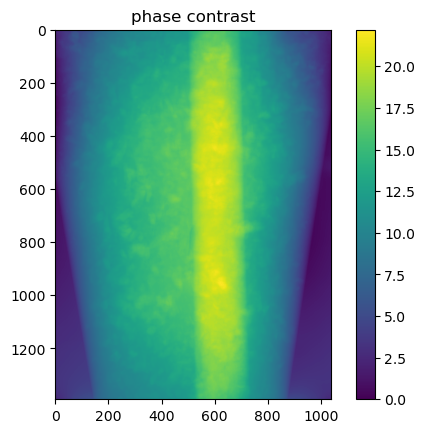

In [22]:
# fig, ax = plt.subplots(1,2, figsize=(6,4))

# ax[0].imshow(np.average(phantom[slice], axis=0), cmap='gray')
# ax[0].set_title('brightfield (sum)')
# ax[0].axis('off')

plt.imshow(phi/(1e3*e*im_width), cmap='viridis')
plt.title('phase contrast')
# plt.axis('off')
plt.colorbar()

Now altogether, do it for all the projections

In [23]:
num_projections = 400
phase_contrast = np.zeros((num_projections, im_height, im_width))

for i in tqdm(range(num_projections)):
    phi = do_fourier_integration(left_right[i], top_bottom[i], freq_x, freq_y)
    phase_contrast[i] = phi

100%|██████████| 400/400 [02:18<00:00,  2.89it/s]


Background testing

In [ ]:
# background.shape

(4, 1392, 1040)

In [ ]:
# NA = 0.03 # Numerical aperture of f/d
# lamb = 0.650 # in microns
# factor = 2*np.pi/lamb*NA
# left_right_bg = NA* (background[1] - background[0])/np.sum(background[0:2])
# top_bottom_bg = NA* (background[2] - background[3])/np.sum(background[2:])

# phi_bg = do_fourier_integration(left_right_bg, top_bottom_bg, freq_x, freq_y)
# plt.imshow(phi_bg*e*1e6*im_width)
# plt.colorbar()

In [ ]:
# left_right_bg = NA* (background[1]/background[1] - background[0]/background[0])/np.sum(background[0:2]/background[0:2])
# top_bottom_bg = NA* (background[2]/background[2] - background[3]/background[3])/np.sum(background[2:]/background[2:])

# phi_bg = do_fourier_integration(left_right_bg, top_bottom_bg, freq_x, freq_y)
# plt.imshow(phi_bg*e*1e6*im_width)
# plt.colorbar()

Scale the image

In [24]:
del phantom

In [25]:
# phase_contrast_subtracted = (phase_contrast - np.array(means)[:,None,None])* e*1e6*im_width
phase_contrast_subtracted = -(phase_contrast - np.max(phase_contrast, axis=(1,2))[:,None,None])* (e*1e3*im_width) 

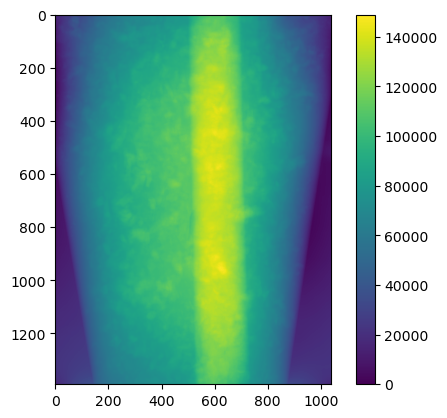

In [26]:
plt.imshow(phase_contrast_subtracted[0] )
plt.colorbar()

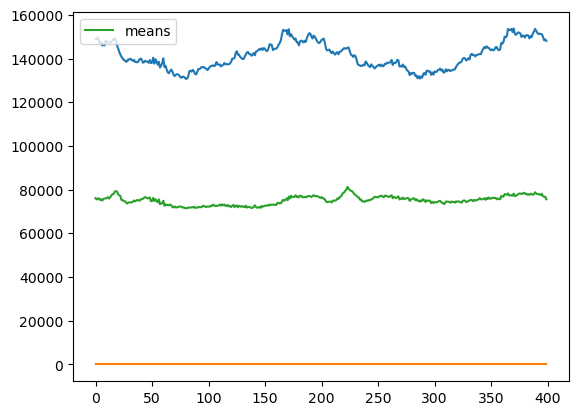

In [27]:
# minimums = []
# maximums = []
# means = []
# std = [] 
# for i in range(400):
#     minimums.append(np.min(phase_contrast[i]))
#     maximums.append(np.max(phase_contrast[i]))
#     means.append(np.mean(phase_contrast[i]))
#     std.append(np.std(phase_contrast[i]))

plt.plot(np.max(phase_contrast_subtracted, axis=(1,2)))
plt.plot(np.min(phase_contrast_subtracted, axis=(1,2)))
plt.plot(np.mean(phase_contrast_subtracted, axis=(1,2)), label='means')
plt.legend()
plt.show()
# plt.plot(std)

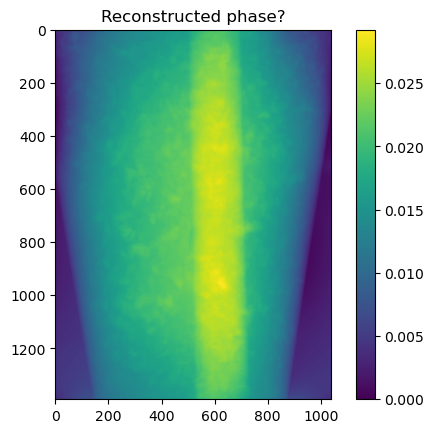

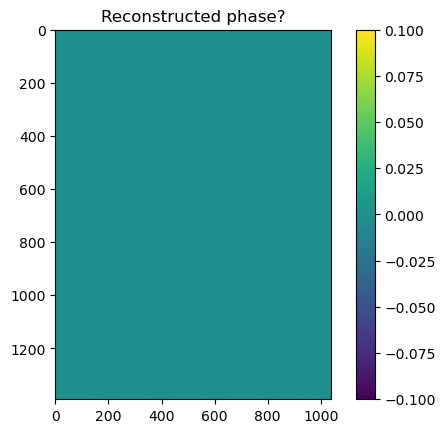

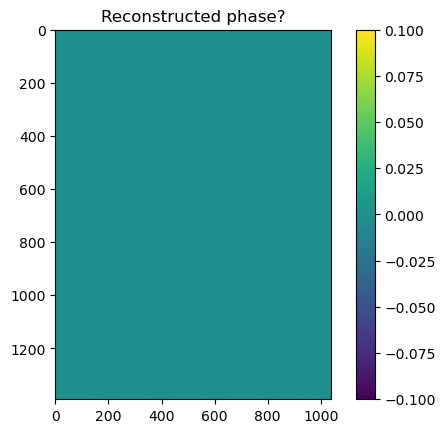

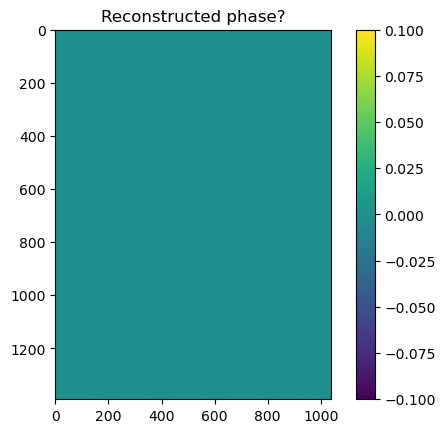

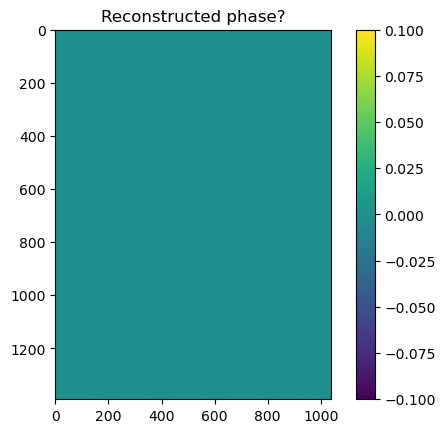

KeyboardInterrupt: 

In [ ]:
for i in np.arange(0,400,50):
    plt.imshow(phase_contrast_subtracted[i])
    plt.colorbar()
    plt.title('Reconstructed phase?')
    plt.show()

In [28]:
import pickle
with open('2023-04-16 agarose-phantom-fourier-bgdivide-imag-addmin.pkl', 'wb') as f:
    pickle.dump(phase_contrast_subtracted, f)

Save as tiff

In [ ]:
# io.imsave('2023-03-22 phase_contrast.tiff', ( phase_contrast_subtracted).astype('uint16') )